<a href="https://colab.research.google.com/github/wenqiglantz/rag-notebook-to-microservices/blob/main/sentence_window_node_parser_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metadata replacement + node sentence window for a RAG pipeline

This notebook demonstrates how to use Metadata replacement + node sentence window in a RAG pipeline.

`SentenceWindowNodeParser` is a tool that can be used to create representations of sentences that consider the surrounding words and sentences. During retrieval, before passing the retrieved sentences to the LLM, the single sentences are replaced with a window containing the surrounding sentences using the `MetadataReplacementNodePostProcessor`. This can be useful for tasks such as machine translation or summarization, where it is essential to understand the meaning of the sentence in its entirety. This is most useful for large documents, as it helps to retrieve more fine-grained details.

Image source: https://twitter.com/jerryjliu0/status/1708147687084986504

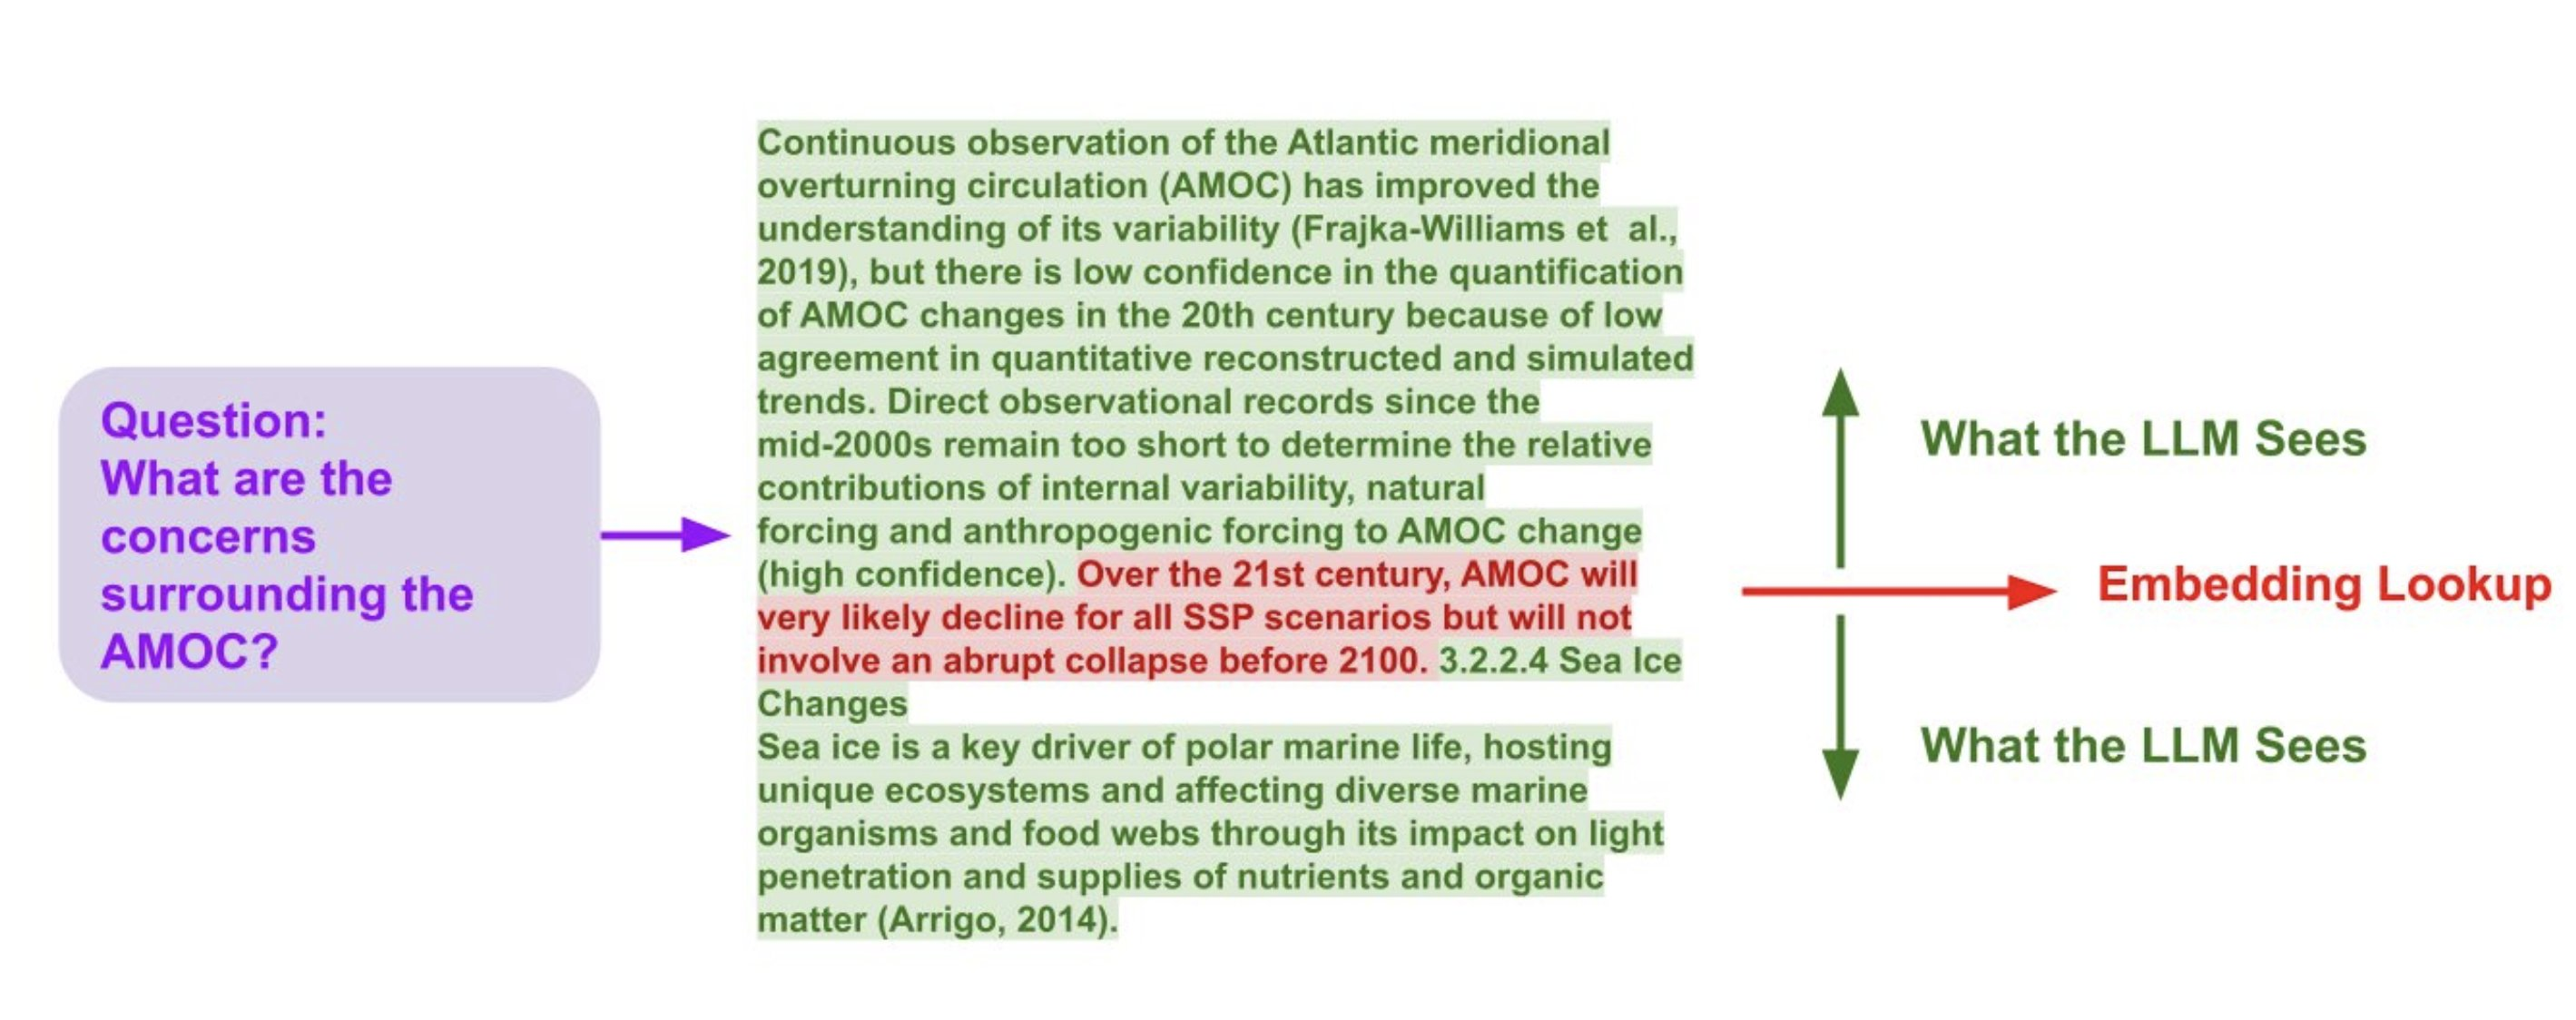

In [1]:
%pip install -q llama-index-embeddings-openai
%pip install -q llama-index-embeddings-huggingface
%pip install -q llama-index-llms-openai
%pip install -q llama-index-postprocessor-cohere-rerank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -q llama_index pypdf sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 46.5 MB/s eta 0:00:00


In [3]:
import os, openai, logging, sys
from google.colab import userdata

# set OpenAI API key in environment variable
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

### Load documents

In [4]:
!mkdir data
!wget https://docs.nvidia.com/ai-enterprise/latest/pdf/nvidia-ai-enterprise-user-guide.pdf -O ./data/nvidia-ai-enterprise-user-guide.pdf

--2024-02-21 02:57:26--  https://docs.nvidia.com/ai-enterprise/latest/pdf/nvidia-ai-enterprise-user-guide.pdf
Resolving docs.nvidia.com (docs.nvidia.com)... 23.211.118.195, 23.211.118.193
Connecting to docs.nvidia.com (docs.nvidia.com)|23.211.118.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/pdf]
Saving to: ‘./data/nvidia-ai-enterprise-user-guide.pdf’

./data/nvidia-ai-en     [   <=>              ]   3.15M  6.93MB/s    in 0.5s    

2024-02-21 02:57:27 (6.93 MB/s) - ‘./data/nvidia-ai-enterprise-user-guide.pdf’ saved [3303568]



### Set up node parser

In [5]:
from llama_index.core import set_global_service_context
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceWindowNodeParser, SimpleNodeParser

# create the sentence window node parser
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=3,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)

llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)
embed_model = HuggingFaceEmbedding(
    model_name="sentence-transformers/all-mpnet-base-v2", max_length=512
)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

### Extract nodes and build index

In [6]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader

document_list = SimpleDirectoryReader("data").load_data()
nodes = node_parser.get_nodes_from_documents(document_list)
index = VectorStoreIndex(nodes, embed_model=embed_model)

### Define query engine

In [8]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor
from llama_index.postprocessor.cohere_rerank import CohereRerank
from google.colab import userdata

os.environ["COHERE_API_KEY"] = userdata.get("COHERE_API_KEY")
api_key = os.environ["COHERE_API_KEY"]

cohere_rerank = CohereRerank(api_key=api_key, top_n=2) # return top 2 nodes from reranker

metadata_query_engine = index.as_query_engine(
    similarity_top_k=2,
    llm=llm,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window"),
        cohere_rerank
    ],
)

### Run test queries

In [9]:
query = "Tell me the high level sequence of instructions to set up a single Ubuntu VM to use NVIDIA vGPU."
response = metadata_query_engine.query(query)
print(str(response))

To set up a single Ubuntu VM to use NVIDIA vGPU, follow these high-level steps:
1. Add the necessary options to the QEMU command line for each vGPU you want to add to the VM.
2. Ensure that the default video device is prevented from loading into the VM by adding a video element.
3. Install an alternate means of accessing the VM, such as VMware Horizon or a VNC server, as the VM console in the vSphere Web Client will not be available when running vGPU.
4. Configure the vSphere VM with NVIDIA vGPU based on your VMware vSphere version.
5. Start the VM and use VMware Horizon or VNC to access the VM's desktop.
6. After the VM has booted, install the NVIDIA AI Enterprise graphics driver following the instructions provided in the documentation.
